In [1]:
%matplotlib inline



Filtering and resampling data
=============================

Some artifacts are restricted to certain frequencies and can therefore
be fixed by filtering. An artifact that typically affects only some
frequencies is due to the power line.

Power-line noise is a noise created by the electrical network.
It is composed of sharp peaks at 50Hz (or 60Hz depending on your
geographical location). Some peaks may also be present at the harmonic
frequencies, i.e. the integer multiples of
the power-line frequency, e.g. 100Hz, 150Hz, ... (or 120Hz, 180Hz, ...).

This tutorial covers some basics of how to filter data in MNE-Python.
For more in-depth information about filter design in general and in
MNE-Python in particular, check out `tut_background_filtering`.



/home/abolfazl/mne_data/MNE-sample-data


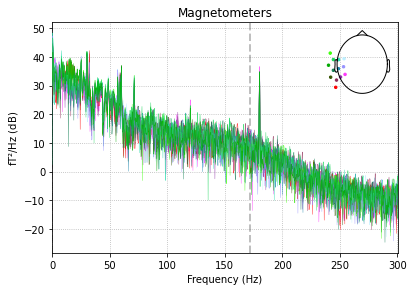

In [8]:
import numpy as np
import mne
from mne.datasets import sample

data_path = sample.data_path()
print(data_path)
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
proj_fname = data_path + '/MEG/sample/sample_audvis_eog_proj.fif'

tmin, tmax = 0, 20  # use the first 20s of data

# Setup for reading the raw data (save memory by cropping the raw data
# before loading it)
raw = mne.io.read_raw_fif(raw_fname)
raw.crop(tmin, tmax).load_data()
raw.info['bads'] = ['MEG 2443', 'EEG 053']  # bads + 2 more
# print(raw.info)

fmin, fmax = 2, 300  # look at frequencies between 2 and 300Hz
n_fft = 2048  # the FFT size (n_fft). Ideally a power of 2

# Pick a subset of channels (here for speed reason)
selection = mne.read_selection('Left-temporal')
picks = mne.pick_types(raw.info, 
                       meg='mag', 
                       eeg=False, 
                       eog=False,
                       stim=False, 
                       exclude='bads', 
                       selection=selection)

# Let's first check out all channel types
raw.plot_psd(area_mode='range', tmax=10.0, 
             picks=picks, average=False);

Removing power-line noise with notch filtering
----------------------------------------------

Removing power-line noise can be done with a Notch filter, directly on the
Raw object, specifying an array of frequency to be cut off:



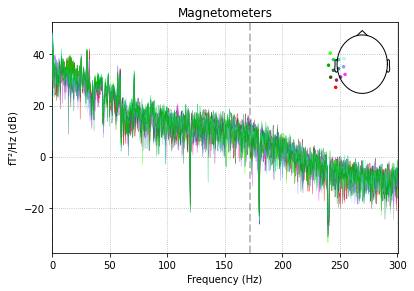

In [9]:
raw.notch_filter(np.arange(60, 241, 60), 
                 picks=picks, 
                 filter_length='auto',
                 phase='zero')
raw.plot_psd(area_mode='range', tmax=10.0, 
             picks=picks, average=False);

Removing power-line noise with low-pass filtering
-------------------------------------------------

If you're only interested in low frequencies, below the peaks of power-line
noise you can simply low pass filter the data.



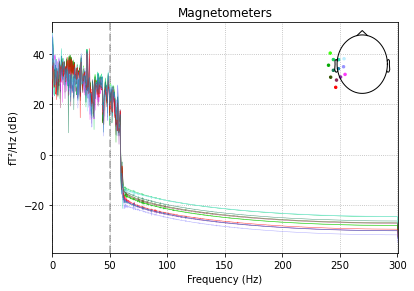

In [4]:
# low pass filtering below 50 Hz
raw.filter(None, 50., 
           h_trans_bandwidth='auto', 
           filter_length='auto',
           phase='zero')
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False);

High-pass filtering to remove slow drifts
-----------------------------------------

To remove slow drifts, you can high pass.

<div class="alert alert-danger"><h4>Warning</h4><p>There can be issues using high-passes greater than 0.1 Hz
             (see examples in `tut_filtering_hp_problems`),
             so apply high-pass filters with caution.</p></div>



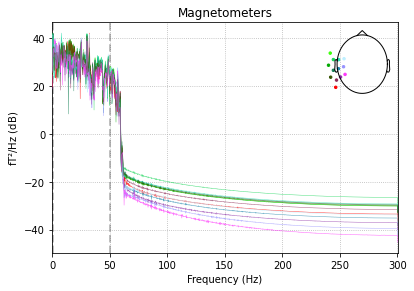

In [5]:
raw.filter(1.0, None, l_trans_bandwidth='auto', 
           filter_length='auto',
           phase='zero')
raw.plot_psd(area_mode='range', 
             tmax=10.0, 
             picks=picks, 
             average=False);

To do the low-pass and high-pass filtering in one step you can do
a so-called *band-pass* filter by running the following:



In [10]:
# band-pass filtering in the range 1 Hz - 50 Hz
raw.filter(1, 50., l_trans_bandwidth='auto', 
           h_trans_bandwidth='auto',
           filter_length='auto', 
           phase='zero')

<Raw | sample_audvis_raw.fif, 376 x 12013 (20.0 s), ~38.1 MB, data loaded>

Downsampling and decimation
---------------------------

When performing experiments where timing is critical, a signal with a high
sampling rate is desired. However, having a signal with a much higher
sampling rate than necessary needlessly consumes memory and slows down
computations operating on the data. To avoid that, you can downsample
your time series. Since downsampling raw data reduces the timing precision
of events, it is recommended only for use in procedures that do not require
optimal precision, e.g. computing EOG or ECG projectors on long recordings.

<div class="alert alert-info"><h4>Note</h4><p>A *downsampling* operation performs a low-pass (to prevent
          aliasing) followed by *decimation*, which selects every
          $N^{th}$ sample from the signal. See
          :func:`scipy.signal.resample` and
          :func:`scipy.signal.resample_poly` for examples.</p></div>

Data resampling can be done with *resample* methods.



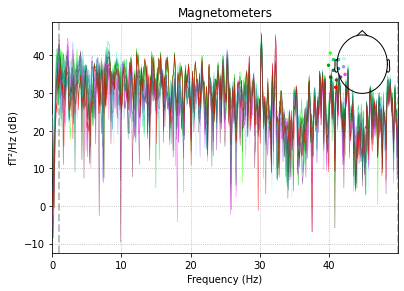

In [7]:
raw.resample(100, npad="auto")  # set sampling frequency to 100Hz
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks);

To avoid this reduction in precision, the suggested pipeline for
processing final data to be analyzed is:

   1. low-pass the data with :meth:`mne.io.Raw.filter`.
   2. Extract epochs with :class:`mne.Epochs`.
   3. Decimate the Epochs object using :meth:`mne.Epochs.decimate` or the
      ``decim`` argument to the :class:`mne.Epochs` object.

We also provide the convenience methods :meth:`mne.Epochs.resample` and
:meth:`mne.Evoked.resample` to downsample or upsample data, but these are
less optimal because they will introduce edge artifacts into every epoch,
whereas filtering the raw data will only introduce edge artifacts only at
the start and end of the recording.

